In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import csv
import os
import sqlite3
import requests
import pprint
import json
import pandas as pd
from bs4 import BeautifulSoup
import csv
import datetime
from requests.structures import CaseInsensitiveDict
import os
import re
os.chdir('/Users/guotang/Desktop/510/proj/')

In [16]:
def filter_rating():
    parks = pd.read_csv("saved_datasets/park_rating.csv")
    parks = parks['parks'].tolist()
    parks_tuple = tuple(parks)

    groceries = pd.read_csv("saved_datasets/grocery_rating.csv")['groceryStore'].tolist()
    groceries_tuple = tuple(groceries)

    schools = pd.read_csv("saved_datasets/school_high_rating.csv")['schools'].tolist()
    schools_tuple = tuple([name + '%' for name in schools])
    
    conn = sqlite3.connect('510project.db')

    parks_placeholders = ', '.join('?' * len(parks))
    groceries_placeholders = ', '.join('?' * len(groceries))
    school_conditions = " OR ".join(["p.name LIKE ?" for _ in schools])
    school_params = tuple([f"{school}%" for school in schools])

    # SQL query
    sql_query = f"""
    SELECT
        p.*
    FROM
        PLACESAROUND p
    WHERE 
    (p.category = 'school' AND ({school_conditions})) OR 
    (p.category = 'grocery store' AND p.name IN ({groceries_placeholders})) OR
    (p.category = 'park' AND p.name IN ({parks_placeholders}))
    """
    
    df = pd.read_sql_query(sql_query, conn, params=school_params + groceries_tuple + parks_tuple)
    df.to_csv("saved_datasets/places_filter.csv", index=False)
    conn.close()
    return df

filter_rating()

,id,zpid,name,category
0,2,25542243,Aliso and Wood Canyons Wilderness Park,park
1,19,25542306,Aliso and Wood Canyons Wilderness Park,park
2,36,25542498,Aliso and Wood Canyons Wilderness Park,park
3,53,25542327,Aliso and Wood Canyons Wilderness Park,park
4,71,25542140,Aliso and Wood Canyons Wilderness Park,park
...,...,...,...,...
8551,39970,59724663,Hurless Barton Park,park
8552,39977,79812759,Vons,grocery store
8553,39978,79812759,Yorba Linda High School,school
8554,39990,250188951,Yorba Linda Middle School,school


In [17]:
def placescounter_csv():      
    # Count places from "places_around.csv"
    places_around = pd.read_csv('saved_datasets/places_filter.csv')
    category_counts = places_around.groupby(['zpid', 'category']).size().unstack(fill_value=0)
    category_counts.columns = [f'{col} count' for col in category_counts.columns]
    category_counts = category_counts.reset_index()
    category_counts['zpid'] = category_counts['zpid']
    category_counts.to_csv('saved_datasets/placesCount.csv', index=False) 
    print(category_counts.dtypes)   
placescounter_csv()

zpid                   int64
grocery store count    int64
park count             int64
school count           int64
dtype: object


In [18]:
def placesCount_table():
    conn = sqlite3.connect('510project.db', detect_types=sqlite3.PARSE_DECLTYPES|sqlite3.PARSE_COLNAMES)
    cur = conn.cursor()
    df = pd.read_csv("saved_datasets/placesCount.csv")
    
    df['zpid'] = df['zpid'].astype(str)
    df['grocery store count'] = df['grocery store count'].astype(int)
    df['park count'] = df['park count'].astype(int)
    df['school count'] = df['school count'].astype(int)
    print(df.dtypes)
    
    # Create table
    cur.execute('DROP TABLE IF EXISTS PLACESCOUNT')
    cur.execute(
        '''
        CREATE TABLE IF NOT EXISTS PLACESCOUNT (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            zpid TEXT,
            groceryCount INTEGER,
            parkCount INTEGER,
            schoolCount INTEGER,
            FOREIGN KEY (zpid) REFERENCES HOUSES(zpid)
        )''')
    for index, row in df.iterrows():
        zpid = row['zpid']
        groceryCount = row['grocery store count']
        parkCount = row['park count']
        schoolCount = row['school count']

        cur.execute(
            'INSERT INTO PLACESCOUNT (zpid, groceryCount, parkCount, schoolCount) VALUES (?, ?, ?, ?)', 
        (zpid, groceryCount, parkCount, schoolCount))
    
    table = pd.read_sql_query('SELECT * FROM PLACESCOUNT LIMIT 5', conn)
    print(table)
    
    conn.commit()
    conn.close()
placesCount_table()

zpid                   object
grocery store count     int64
park count              int64
school count            int64
dtype: object
   id      zpid  groceryCount  parkCount  schoolCount
0   1  21122605             1          1            2
1   2  21122611             1          1            2
2   3  25092451             0          0            1
3   4  25094063             0          0            1
4   5  25102510             0          0            2


FILETER

In [3]:
import numpy as np
def join_tables():

    conn = sqlite3.connect('510project.db')

    # SQL query
    sql_query = """
    SELECT
        h.*,
        h.price / h.livingArea AS price_per_sqft,
        p.groceryCount AS grocery_count,
        p.parkCount AS park_count,
        p.schoolCount AS school_count,
        i.income AS local_income
    FROM
        HOUSES h
    LEFT JOIN PLACESCOUNT p ON h.zpid = p.zpid
    LEFT JOIN OCINCOMEBYZIP i ON h.zipcode = i.zipcode
    """
    df = pd.read_sql_query(sql_query, conn)
    df['builtYear'] = df['builtYear'].str[:-1].astype(int)
    df['local_income'] = df['local_income'].replace(r'[\$,]', '', regex=True).astype(float)

    conn.close()
    return df

wholeTable = join_tables()
wholeTable.head()



,zpid,city,zipcode,yearSold,propertyType,price,bedrooms,bathrooms,livingArea,builtYear,longitude,latitude,daysOnZillow,price_per_sqft,grocery_count,park_count,school_count,local_income
0,25542243,Aliso Viejo,92656,2024,SINGLE_FAMILY,670000.0,3,2.0,1240.0,1970,-117.722595,33.602184,17,540.322581,0.0,1.0,0.0,74688.0
1,25542306,Aliso Viejo,92656,2024,SINGLE_FAMILY,632000.0,3,2.0,1240.0,1970,-117.72207,33.601254,48,509.677419,0.0,1.0,0.0,74688.0
2,25542498,Aliso Viejo,92656,2024,SINGLE_FAMILY,720000.0,3,2.0,1240.0,1970,-117.7205,33.60195,68,580.645161,0.0,1.0,0.0,74688.0
3,25542327,Aliso Viejo,92656,2024,TOWNHOUSE,675000.0,3,2.0,1240.0,1970,-117.72102,33.60096,80,544.354839,0.0,1.0,0.0,74688.0
4,25542140,Aliso Viejo,92656,2024,SINGLE_FAMILY,715000.0,3,2.0,1240.0,1970,-117.72023,33.60348,94,576.612903,0.0,1.0,0.0,74688.0


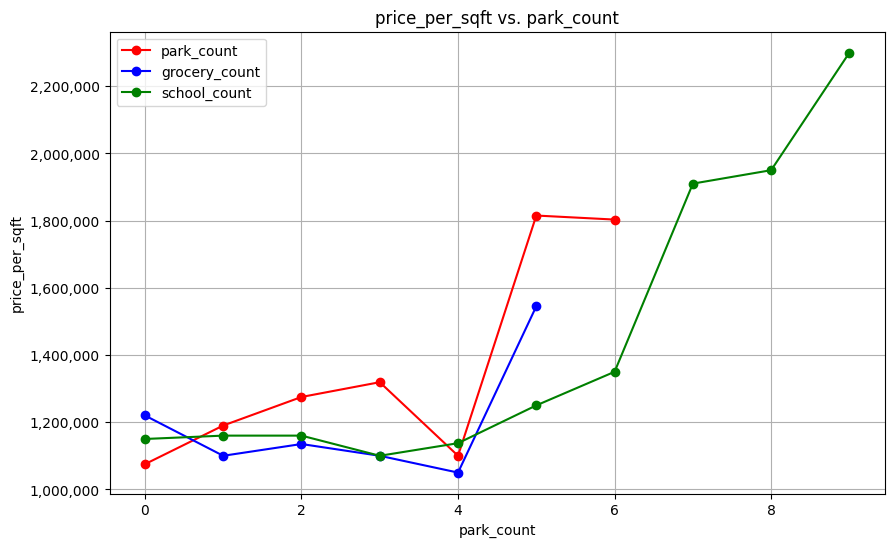

In [13]:
df = wholeTable
# df = df[(df['city'] == 'Irvine')]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
yfeature = 'price_per_sqft'
xfeature = 'park_count'

# filtered_df = df.groupby(['city', xfeature])[yfeature].median().reset_index()

plt.figure(figsize=(10, 6))
for feature, color in zip(['park_count', 'grocery_count', 'school_count'], ['red', 'blue', 'green']):
    grouped_data = df.groupby(feature)['price'].median().reset_index()
    plt.plot(grouped_data[feature], grouped_data['price'], label=f'{feature}', color=color, marker='o', linestyle='-')

    
plt.title(f'{yfeature} vs. {xfeature}')
plt.xlabel(xfeature)
plt.ylabel(yfeature)
plt.grid(True)


# Calculate coefficients of a linear regression
# coefficients = np.polyfit(filtered_df[xfeature], filtered_df[yfeature], 1)
# polynomial = np.poly1d(coefficients)

# xs = np.linspace(filtered_df[xfeature].min(), filtered_df[yfeature].max())
# ys = polynomial(xs)
# plt.plot(xs, ys, color='red')  # plot regression line
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x):,}')
plt.gca().yaxis.set_major_formatter(formatter)
# plt.xlim(min(filtered_df[xfeature]), max(filtered_df[xfeature]))
# plt.ylim(min(filtered_df[yfeature]), max(filtered_df[yfeature]))
plt.legend()
plt.show()


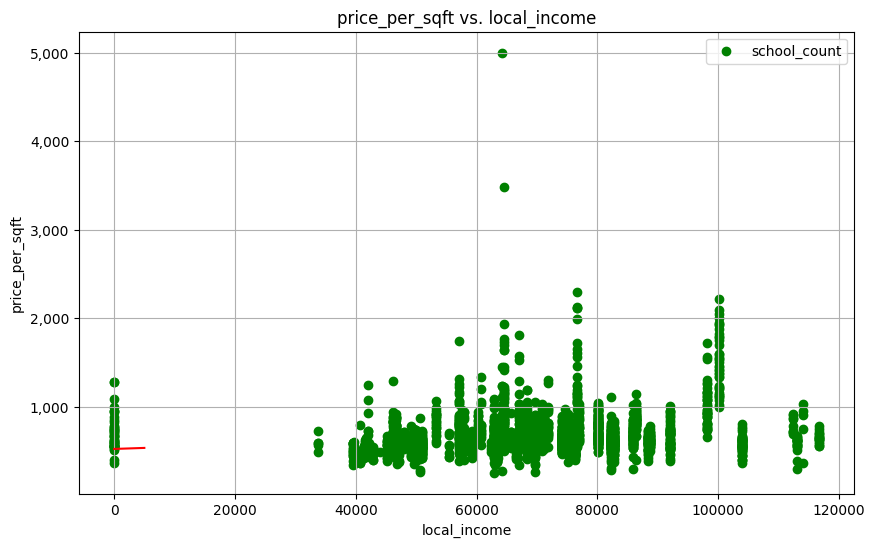

In [15]:
yfeature = 'price_per_sqft'
xfeature = 'local_income'
filtered_df = df
# filtered_df = df.groupby(['city', xfeature])[yfeature].median().reset_index()

plt.figure(figsize=(10, 6))

plt.scatter(filtered_df[xfeature], filtered_df[yfeature], label=f'{feature}', color=color, marker='o', linestyle='-')

    
plt.title(f'{yfeature} vs. {xfeature}')
plt.xlabel(xfeature)
plt.ylabel(yfeature)
plt.grid(True)


# Calculate coefficients of a linear regression
coefficients = np.polyfit(filtered_df[xfeature], filtered_df[yfeature], 1)
polynomial = np.poly1d(coefficients)

xs = np.linspace(filtered_df[xfeature].min(), filtered_df[yfeature].max())
ys = polynomial(xs)
plt.plot(xs, ys, color='red')  # plot regression line
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x):,}')
plt.gca().yaxis.set_major_formatter(formatter)
# plt.xlim(min(filtered_df[xfeature]), max(filtered_df[xfeature]))
# plt.ylim(min(filtered_df[yfeature]), max(filtered_df[yfeature]))
plt.legend()
plt.show()

modeling

In [5]:
columns_to_check = ['price', 'livingArea', 'bedrooms', 'bathrooms']


for column in columns_to_check:
    Q1 = wholeTable[column].quantile(0.15)
    Q3 = wholeTable[column].quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    wholeTable = wholeTable[(wholeTable[column] >= lower_bound) & (wholeTable[column] <= upper_bound)]

In [6]:
wholeTable.dropna(inplace=True)
wholeTable.head()

,zpid,city,zipcode,yearSold,propertyType,price,bedrooms,bathrooms,livingArea,builtYear,longitude,latitude,daysOnZillow,price_per_sqft,grocery_count,park_count,school_count,local_income
0,25542243,Aliso Viejo,92656,2024,SINGLE_FAMILY,670000.0,3,2.0,1240.0,1970,-117.722595,33.602184,17,540.322581,0.0,1.0,0.0,74688.0
1,25542306,Aliso Viejo,92656,2024,SINGLE_FAMILY,632000.0,3,2.0,1240.0,1970,-117.72207,33.601254,48,509.677419,0.0,1.0,0.0,74688.0
2,25542498,Aliso Viejo,92656,2024,SINGLE_FAMILY,720000.0,3,2.0,1240.0,1970,-117.7205,33.60195,68,580.645161,0.0,1.0,0.0,74688.0
3,25542327,Aliso Viejo,92656,2024,TOWNHOUSE,675000.0,3,2.0,1240.0,1970,-117.72102,33.60096,80,544.354839,0.0,1.0,0.0,74688.0
4,25542140,Aliso Viejo,92656,2024,SINGLE_FAMILY,715000.0,3,2.0,1240.0,1970,-117.72023,33.60348,94,576.612903,0.0,1.0,0.0,74688.0


In [24]:
wholeTable_encoded = pd.get_dummies(wholeTable, columns=['propertyType', 'city'])
columns_to_drop = ['zpid', 'longitude', 'latitude', 'zipcode', 'local_income', 'price_per_sqft', 'daysOnZillow','yearSold']
wholeTable_encoded = wholeTable_encoded.drop(columns_to_drop, axis=1)
wholeTable_encoded.head()
wholeTable_encoded.to_csv("encoded_house_data_whole.csv", index=False)

In [25]:
# Separate features and target
X = wholeTable_encoded.drop('price', axis=1)
y = wholeTable_encoded['price']

In [26]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 92537584589.5942
R^2 Score: 0.818738054587597


In [68]:
from sklearn.linear_model import Lasso

# Example usage:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

y_pred =lasso_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 92537699622.38539
R^2 Score: 0.818737829262205


/Users/guotang/anaconda3/envs/py312/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.199e+13, tolerance: 1.022e+11
  model = cd_fast.enet_coordinate_descent(


In [69]:
wholeTable_encoded.head()

,price,bedrooms,bathrooms,livingArea,builtYear,grocery_count,park_count,school_count,propertyType_CONDO,propertyType_SINGLE_FAMILY,...,city_San Clemente,city_San Juan Capistrano,city_Santa Ana,city_Seal Beach,city_Stanton,city_Trabuco Canyon,city_Tustin,city_Villa Park,city_Westminster,city_Yorba Linda
0,670000.0,3,2.0,1240.0,1970,0.0,1.0,0.0,False,True,...,False,False,False,False,False,False,False,False,False,False
1,632000.0,3,2.0,1240.0,1970,0.0,1.0,0.0,False,True,...,False,False,False,False,False,False,False,False,False,False
2,720000.0,3,2.0,1240.0,1970,0.0,1.0,0.0,False,True,...,False,False,False,False,False,False,False,False,False,False
3,675000.0,3,2.0,1240.0,1970,0.0,1.0,0.0,False,False,...,False,False,False,False,False,False,False,False,False,False
4,715000.0,3,2.0,1240.0,1970,0.0,1.0,0.0,False,True,...,False,False,False,False,False,False,False,False,False,False


In [70]:
import pickle

filename = 'lasso_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(lasso_model, file)

# Load the model from disk
with open(filename, 'rb') as file:
    loaded_model = pickle.load(file)

In [77]:

columns = wholeTable_encoded.drop('price', axis=1).columns
new_data = pd.DataFrame({
    'bedrooms': [2],
    'city_Irvine': [1],
    'bathrooms': [2],
    'builtYear': [2000],
    'livingArea': [1200],
    'propertyType_CONDO': [1],
    'propertyType_SINGLE_FAMILY': [0],
    'grocery_count': [1],
    'park_count': [0],
    'school_count': [0]
}, columns=columns) 
new_data.fillna(False, inplace=True)
predicted_price = lasso_model.predict(new_data)
print(f"Predicted Price: ${predicted_price[0]:,.2f}")

Predicted Price: $1,051,662.48


/var/folders/tf/n5jbsgms38s6j4s_3kjqk1q40000gn/T/ipykernel_14367/1260471932.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_data.fillna(False, inplace=True)
